### Code Paramethers

* Labels: All
* Size: (28,28)
* Data augmentation: YES (without generators and chances for caracteristics)
* Model Layers: 2 conv2D (64,64), 2 dense layers and relu in all layers
* Testing implemented
* New Dataset suffled

### Defining Dataset Path

In [48]:
import os
dataset_directory = 'D:\\.Dataset05032024 - TCC\\labels'
os.makedirs(dataset_directory, exist_ok=True)
os.chdir(dataset_directory)

### Loading Data into train, validation and teste folders

In [49]:
from shutil import copyfile
from sklearn.model_selection import train_test_split

In [50]:
train_directory = 'D:\\.Dataset05032024 - TCC\\result\\train'
validation_directory = 'D:\\.Dataset05032024 - TCC\\result\\validate'
test_directory = 'D:\\.Dataset05032024 - TCC\\result\\test'

In [4]:
def load_data_into_train_validation_test(dataset_directory, train_directory, validation_directory, test_directory):
    
    # Lista de pastas de classe (uma pasta para cada classe de roupa)
    class_folders = os.listdir(dataset_directory)
    
    # Porcentagem de imagens para validação e teste (10% para cada)
    validation_percent = 0.17
    test_percent = 0.14
    
    # Loop através de cada pasta de classe
    for class_folder in class_folders:
    
        # Diretório completo da pasta de classe original
        class_folder_path = os.path.join(dataset_directory, class_folder)
    
        # Lista de todas as imagens na pasta de classe
        images = os.listdir(class_folder_path)
    
        # Calcule o número de imagens a serem movidas para validação e teste
        validation_images_quantity = int(len(images) * validation_percent)
        test_images_quantity = int(len(images) * test_percent)
    
        # Divida as imagens em treinamento, validação e teste
        train_images = images[validation_images_quantity + test_images_quantity:]
        validation_images = images[:validation_images_quantity]
        test_images = images[validation_images_quantity:validation_images_quantity + test_images_quantity]
        # print("train_images", train_images)
    
        # Crie diretórios para treinamento, validação e teste para a classe atual
        train_class_directory = os.path.join(train_directory, class_folder)
        validation_class_directory = os.path.join(validation_directory, class_folder)
        test_class_directory = os.path.join(test_directory, class_folder)
    
        # print("train_class_directory", train_class_directory)
        # print("validation_class_directory", validation_class_directory)
        # print("test_class_directory", test_class_directory)

        os.makedirs(train_class_directory, exist_ok=True)
        os.makedirs(validation_class_directory, exist_ok=True)
        os.makedirs(test_class_directory, exist_ok=True)

        # Mova as imagens para os diretórios correspondentes
        for image in train_images:
            # print("image", image)
            src = os.path.join(class_folder_path, image)
            # print("scr", src)
            dst = os.path.join(train_class_directory, image)
            # print("dst", dst)
            copyfile(src, dst)
    
        for image in validation_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(validation_class_directory, image)
            copyfile(src, dst)
    
        for image in test_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(test_class_directory, image)
            copyfile(src, dst)

In [5]:
load_data_into_train_validation_test(dataset_directory, train_directory, validation_directory, test_directory)

### Defining Pre Processing (Redefinition and Normalization)

In [51]:
target_size = (28, 28) # Tamanho alvo para redimensionamento

def preprocess_image(image_path):
    
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalização dos valores dos pixels para [0, 1]
    
    return img_array

### Saving images with pre-processing definitions

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [8]:
dataset_directories = [train_directory, validation_directory, test_directory]

In [9]:
def saving_images_with_preprocessig_definitions(dataset_directories):

    for dataset_directory in dataset_directories:
    
        # Loop através de cada pasta de classe em treinamento
        for class_folder in os.listdir(dataset_directory):
    
            # Crie uma figura com três subplots em uma linha
            if (dataset_directory == train_directory): fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    
            class_folder_path = os.path.join(dataset_directory, class_folder)
    
            i = 0
            # Loop através de cada imagem na pasta de classe
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
    
                # Pré-processar a imagem
                preprocessed_image = preprocess_image(image_path)
    
                # Salvar a imagem pré-processada de volta ao mesmo local
                array_img = array_to_img(preprocessed_image)
                array_img.save(image_path)
    
                if (dataset_directory == train_directory and i < 3):
                    axs[i].imshow(preprocessed_image)
                    axs[i].axis('off')
                    i += 1
            
    plt.show()

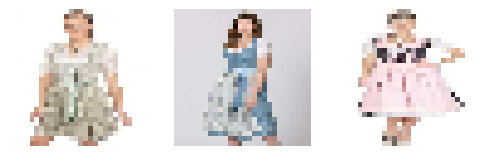

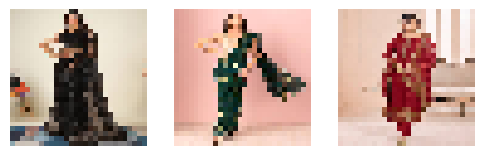

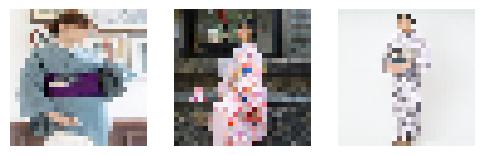

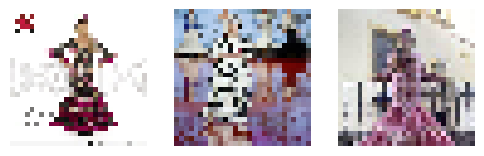

In [10]:
saving_images_with_preprocessig_definitions(dataset_directories)

### Including Augmented Images on Train Directory

In [11]:
import imgaug as ia
from imgaug import augmenters as iaa

In [12]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.1
zoom_range = 0.1
horizontal_flip = True

In [13]:
generating_augmented_images = iaa.Sequential([
    # Virar Horizontalmente
    iaa.Fliplr(p=0.5),
    # Rotação Aleatória
    iaa.Sometimes(0.4, iaa.Affine(rotate=(-rotation_range, rotation_range))),
    # Deslocamento Horizontal e Vertical
    iaa.Sometimes(0.3, iaa.Affine(translate_percent={"x": (-width_shift_range, width_shift_range),
                                                     "y": (-height_shift_range, height_shift_range)})),
    # Zoom Aleatório
    iaa.Sometimes(0.2, iaa.Affine(scale=(1 - zoom_range, 1 + zoom_range))),
    # Sem probabilidade, sempre aplicada
    iaa.Affine(shear=(-shear_range, shear_range)),
], random_order=True)  # Aplica as augmentations em ordem aleatória


In [14]:
from tensorflow.keras.utils import save_img

In [15]:
def including_augmented_images(train_directory):
    
    for class_folder in os.listdir(train_directory):
    
        class_folder_path = os.path.join(train_directory, class_folder)
        images = os.listdir(class_folder_path)
    
        fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_folder_path, image_name)
    
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
    
            # Crie uma lista que contenha a mesma imagem original três vezes
            image_list = [img_array, img_array, img_array]
    
            # Aplicar augmentations à lista de imagens
            augmented_images = generating_augmented_images(images=image_list)
    
            k = 0
            # Salvar as imagens aumentadas no mesmo diretório
            for j, augmented_image in enumerate(augmented_images):
    
                image_name, image_extension = os.path.splitext(image_path)
                new_image_path = f"{image_name}aug_{j+1}_{total_images_generated}{image_extension}"
    
                # Converta a imagem aumentada em um formato válido
                augmented_image = np.uint8(augmented_image)
                save_img(new_image_path, augmented_image)
    
                axs[k].imshow(augmented_image)
                axs[k].axis('off')
                k += 1
    
        plt.show()

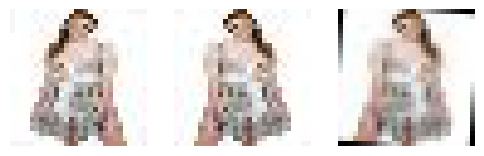

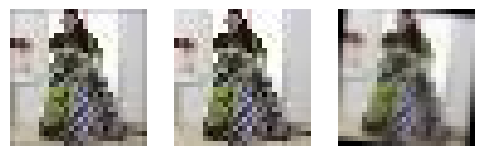

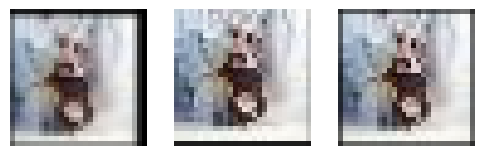

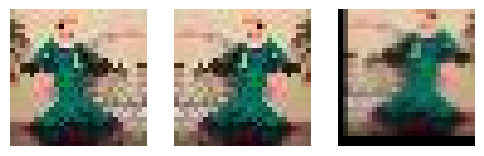

In [16]:
total_images_generated = 3
including_augmented_images(train_directory)

### Defining this Dataset Model variables from train, validation and test folders

In [52]:
import tensorflow as tf

batch_size = 3
target_size = (28, 28)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(train_dataset)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(validation_dataset)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(test_dataset)

Found 16244 files belonging to 4 classes.
Found 997 files belonging to 4 classes.
Found 821 files belonging to 4 classes.


### Creating Model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, PReLU, MaxPooling2D, Flatten, Dense, Dropout

In [54]:
model = tf.keras.Sequential([

    BatchNormalization(input_shape=(28, 28, 3)),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.1),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(4, activation="softmax")
])

In [55]:
model.build(input_shape=(None, 28, 28, 3))

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 28, 28, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)        

### Compiling Model

In [57]:
from tensorflow.keras.optimizers import Adam

In [58]:
adam = Adam(learning_rate=0.001)

In [59]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training Model

###### Defining Callback Methods:

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

*   Checkpoint to save best model weights


In [61]:
checkpoint_path = 'D:\\.Dataset05032024 - TCC\\model_checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

*   Earlystop to stop the training process when the model stops improving



In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=10)

*   TensorBoard to use logs for vizualize whats happening



In [ ]:
!pip install ngrok

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
    --------------------------------------- 0.1/3.2 MB 1.1 MB/s eta 0:00:03
   - -------------------------------------- 0.1/3.2 MB 1.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/3.2 MB 1.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.3/3.2 MB 1.4 MB/s eta 0:00:03
   ---- ----------------------------------- 0.3/3.2 MB 1.4 MB/s eta 0:00:03
   ----- ---------------------------------- 0.4/3.2 MB 1.5 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/3.2 MB 1.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/3.2 MB 1.4 MB/s eta 0:00:02
   ------- -------------------------------- 0.6/3.2 MB 1.5 MB/s eta 0:00:02
   -------- ------------------------------- 0.7/3.2 MB 1.5 MB/s eta 0:00:02
   --------- ------------------------------ 0.7/3.2 MB 1.5 MB/s eta 0:00:02
   ---------- ----------------------------- 0.8/3.2 MB 1.4 MB/s eta 0:00:02
   ----------- ----

In [ ]:
from tensorboard import notebook
import ngrok

In [ ]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# Iniciar o TensorBoard em segundo plano
os.system("tensorboard --logdir ./logs --host 0.0.0.0 --port 6006 &")

In [ ]:
# Abrir um túnel para o TensorBoard
public_url = ngrok.connect(6006, "http")
print("TensorBoard disponível em:", public_url)

### Starting training with defined callbacks

In [62]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [65]:
import time
from tensorflow.keras.callbacks import CSVLogger

start_time = time.time()

history = 'D:\\.Dataset05032024 - TCC\\history.csv'
csv_logger = CSVLogger(filename=history)

history = model.fit(
    train_dataset,                          # Conjunto de dados de treinamento
    epochs=100,                             # Número de épocas de treinamento
    validation_data=validation_dataset,     # Conjunto de dados de validação (separado anteriormente)
    callbacks=[csv_logger, checkpoint], # Callback para salvar os melhores pesos #, early_stopping, tensorboard_callback, activation_logger
    verbose=3                               # Exibir informações de treinamento
)

end_time = time.time()

# Salvar o modelo treinado
model_path_trained = 'D:\\.Dataset05032024 - TCC\\model_trained.h5'
model.save(model_path_trained)

Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.57372, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 2/100

Epoch 2: val_accuracy improved from 0.57372 to 0.59679, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 3/100

Epoch 3: val_accuracy improved from 0.59679 to 0.69408, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 4/100

Epoch 4: val_accuracy improved from 0.69408 to 0.74624, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 5/100

Epoch 5: val_accuracy improved from 0.74624 to 0.78536, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.78536
Epoch 7/100

Epoch 7: val_accuracy improved from 0.78536 to 0.80943, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 8/100

Epoch 8: val_accuracy improved from 0.80943 to 0.82849, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.82849
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.82849
Epoch 11/100

Epoch 11: val_accuracy improved from 0.82849 to 0.85055, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 12/100

Epoch 12: val_accuracy did not improve from 0.85055
Epoch 13/100

Epoch 13: val_accuracy improved from 0.85055 to 0.87262, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.87262
Epoch 15/100

Epoch 15: val_accuracy improved from 0.87262 to 0.88967, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.88967
Epoch 17/100

Epoch 17: val_accuracy improved from 0.88967 to 0.89870, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.89870
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.89870
Epoch 20/100

Epoch 20: val_accuracy improved from 0.89870 to 0.90772, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.90772
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.90772
Epoch 23/100

Epoch 23: val_accuracy improved from 0.90772 to 0.90873, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 24/100

Epoch 24: val_accuracy improved from 0.90873 to 0.92076, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 25/100

Epoch 25: val_accuracy did not improve from 0.92076
Epoch 26/100

Epoch 26: val_accuracy did not improve from 0.92076
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.92076
Epoch 28/100

Epoch 28: val_accuracy did not improve from 0.92076
Epoch 29/100

Epoch 29: val_accuracy improved from 0.92076 to 0.92778, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 30/100

Epoch 30: val_accuracy did not improve from 0.92778
Epoch 31/100

Epoch 31: val_accuracy did not improve from 0.92778
Epoch 32/100

Epoch 32: val_accuracy improved from 0.92778 to 0.92879, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 33/100

Epoch 33: val_accuracy improved from 0.92879 to 0.93180, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 34/100

Epoch 34: val_accuracy did not improve from 0.93180
Epoch 35/100

Epoch 35: val_accuracy did not improve from 0.93180
Epoch 36/100

Epoch 36: val_accuracy did not improve from 0.93180
Epoch 37/100

Epoch 37: val_accuracy did not improve from 0.93180
Epoch 38/100

Epoch 38: val_accuracy did not improve from 0.93180
Epoch 39/100

Epoch 39: val_accuracy did not improve from 0.93180
Epoch 40/100

Epoch 40: val_accuracy did not improve from 0.93180
Epoch 41/100

Epoch 41: val_accuracy did not improve from 0.93180
Epoch 42/100

Epoch 42: val_accuracy did not improve from 0.93180
Epoch 43/100

Epoch 43: val_accuracy did not improve from 0.93180
Epoch 44/100

Epoch 44: val_accuracy did not improve from 0.93180
Epoch 45/100

Epoch 45: val_accuracy did not improve from 0.93180
Epoch 46/100

Epoch 46: val_accuracy improved from 0.93180 to 0.93781, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 47/100

Epoch 47: val_accuracy did not improve from 0.93781
Epoch 48/100

Epoch 48: val_accuracy did not improve from 0.93781
Epoch 49/100

Epoch 49: val_accuracy did not improve from 0.93781
Epoch 50/100

Epoch 50: val_accuracy did not improve from 0.93781
Epoch 51/100

Epoch 51: val_accuracy did not improve from 0.93781
Epoch 52/100

Epoch 52: val_accuracy did not improve from 0.93781
Epoch 53/100

Epoch 53: val_accuracy did not improve from 0.93781
Epoch 54/100

Epoch 54: val_accuracy improved from 0.93781 to 0.94082, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 55/100

Epoch 55: val_accuracy did not improve from 0.94082
Epoch 56/100

Epoch 56: val_accuracy did not improve from 0.94082
Epoch 57/100

Epoch 57: val_accuracy did not improve from 0.94082
Epoch 58/100

Epoch 58: val_accuracy did not improve from 0.94082
Epoch 59/100

Epoch 59: val_accuracy did not improve from 0.94082
Epoch 60/100

Epoch 60: val_accuracy did not improve from 0.94082
Epoch 61/100

Epoch 61: val_accuracy improved from 0.94082 to 0.94283, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 62/100

Epoch 62: val_accuracy did not improve from 0.94283
Epoch 63/100

Epoch 63: val_accuracy did not improve from 0.94283
Epoch 64/100

Epoch 64: val_accuracy did not improve from 0.94283
Epoch 65/100

Epoch 65: val_accuracy did not improve from 0.94283
Epoch 66/100

Epoch 66: val_accuracy did not improve from 0.94283
Epoch 67/100

Epoch 67: val_accuracy did not improve from 0.94283
Epoch 68/100

Epoch 68: val_accuracy did not improve from 0.94283
Epoch 69/100

Epoch 69: val_accuracy did not improve from 0.94283
Epoch 70/100

Epoch 70: val_accuracy improved from 0.94283 to 0.94885, saving model to D:\.Dataset05032024 - TCC\model_checkpoint


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


INFO:tensorflow:Assets written to: D:\.Dataset05032024 - TCC\model_checkpoint\assets


Epoch 71/100

Epoch 71: val_accuracy did not improve from 0.94885
Epoch 72/100

Epoch 72: val_accuracy did not improve from 0.94885
Epoch 73/100

Epoch 73: val_accuracy did not improve from 0.94885
Epoch 74/100

Epoch 74: val_accuracy did not improve from 0.94885
Epoch 75/100

Epoch 75: val_accuracy did not improve from 0.94885
Epoch 76/100

Epoch 76: val_accuracy did not improve from 0.94885
Epoch 77/100

Epoch 77: val_accuracy did not improve from 0.94885
Epoch 78/100

Epoch 78: val_accuracy did not improve from 0.94885
Epoch 79/100

Epoch 79: val_accuracy did not improve from 0.94885
Epoch 80/100

Epoch 80: val_accuracy did not improve from 0.94885
Epoch 81/100

Epoch 81: val_accuracy did not improve from 0.94885
Epoch 82/100

Epoch 82: val_accuracy did not improve from 0.94885
Epoch 83/100

Epoch 83: val_accuracy did not improve from 0.94885
Epoch 84/100

Epoch 84: val_accuracy did not improve from 0.94885
Epoch 85/100

Epoch 85: val_accuracy did not improve from 0.94885
Epoch 86/1

In [66]:
execution_time_seconds = end_time - start_time

hours = int(execution_time_seconds) // 3600
minutes = int(execution_time_seconds) % 3600 // 60
seconds = int(execution_time_seconds) % 60

print(f"Tempo de execução: {hours} horas, {minutes} minutos e {seconds} segundos")

Tempo de execução: 1 horas, 42 minutos e 21 segundos


### Evaluating Model

###### Evaluating Model by Loss and Accuracy with the Test Data

In [67]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print(f'Teste -> Perda: {test_loss}, Acurácia: {test_accuracy}')

Teste -> Perda: 0.23873373866081238, Acurácia: 0.92813640832901


###### Plot Graphs to vizualise loss and accuracy through the epochs

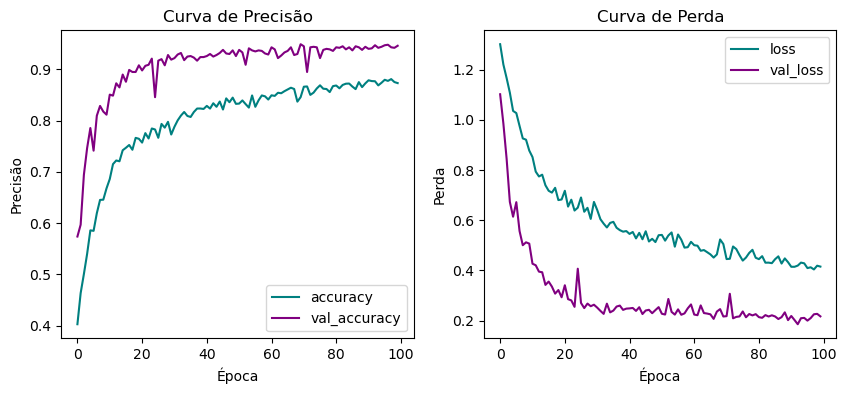

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the history data from the CSV file
df_history = pd.read_csv('D:\\.Dataset05032024 - TCC\\history.csv')

# Extract the desired metrics (accuracy and loss in this case)
accuracy = df_history['accuracy'].to_numpy()
val_accuracy = df_history['val_accuracy'].to_numpy()
loss = df_history['loss'].to_numpy()
val_loss = df_history['val_loss'].to_numpy()

# Plot the curves as usual
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, color='teal', label='accuracy')
plt.plot(val_accuracy, color='purple', label='val_accuracy')
plt.title('Curva de Precisão')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='purple', label='val_loss')
plt.title('Curva de Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

### Other Plots to help evaluate the model

###### Plot Confusion Matrix

A matriz de confusão é uma tabela que mostra as contagens de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. É especialmente útil em problemas de classificação com várias classes.


In [69]:
import keras

print(keras.__version__)

2.9.0


In [70]:
model_path = 'D:\\.Dataset05032024 - TCC\\model_trained.h5'
model = tf.keras.models.load_model(model_path)

274/274 [==============================] - 1s 4ms/step


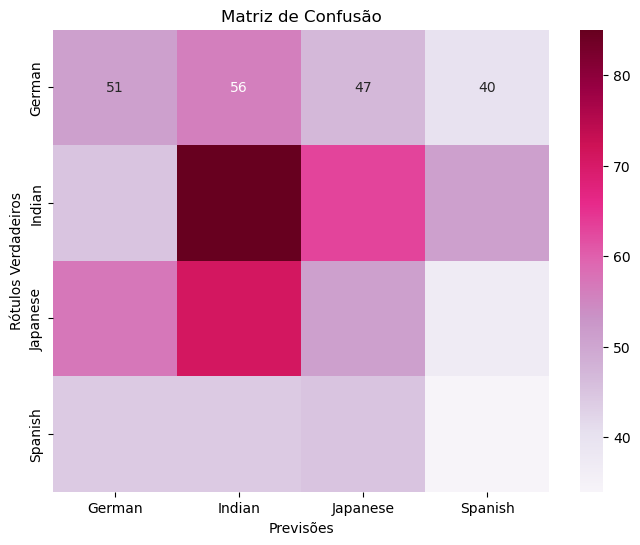

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


# Obter previsões do conjunto de teste
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Use argmax para obter a classe prevista

# Obter rótulos verdadeiros do conjunto de teste
true_labels = [label for _, label in test_dataset.unbatch()]

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Definir rótulos das classes
class_labels = ["German", "Indian", "Japanese", "Spanish"]

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="PuRd", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Previsões")
plt.ylabel("Rótulos Verdadeiros")
plt.title("Matriz de Confusão")
plt.show()

###### Plot Heatmap Error

Criar heatmaps que destacam onde o modelo está cometendo erros pode ajudar a identificar padrões específicos que podem ser melhorados.

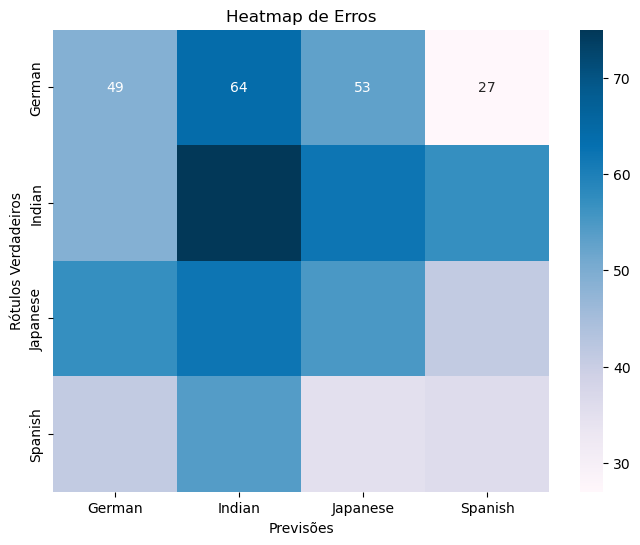

In [72]:
# Obter rótulos verdadeiros do conjunto de teste
true_labels = [label for _, label in test_dataset.unbatch()]

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calcular o heatmap de erros
error_matrix = conf_matrix - np.eye(conf_matrix.shape[0], dtype=int)  # Subtrair a diagonal para obter os erros

# Definir rótulos das classes
class_labels = ["German", "Indian", "Japanese", "Spanish"]

# Visualizar o heatmap de erros
plt.figure(figsize=(8, 6))
sns.heatmap(error_matrix, annot=True, fmt="d", cmap="PuBu", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Previsões")
plt.ylabel("Rótulos Verdadeiros")
plt.title("Heatmap de Erros")
plt.show()

### Evaluating HeatMap

In [73]:
pip install tf-keras-vis

Note: you may need to restart the kernel to use updated packages.


In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils import normalize
import cv2

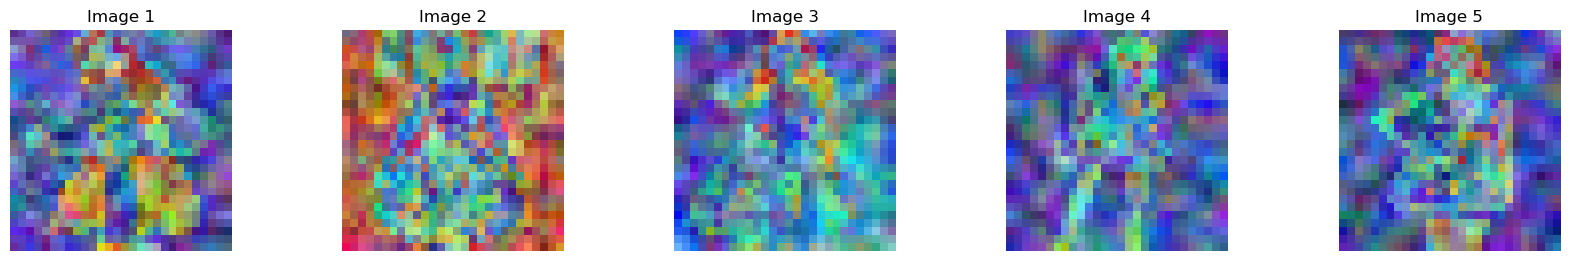

In [75]:
# Caminho para o diretório de teste
test_dir_german = 'D:\\.Dataset28022024 - TCC\\result\\test\\german'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_german)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_german, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

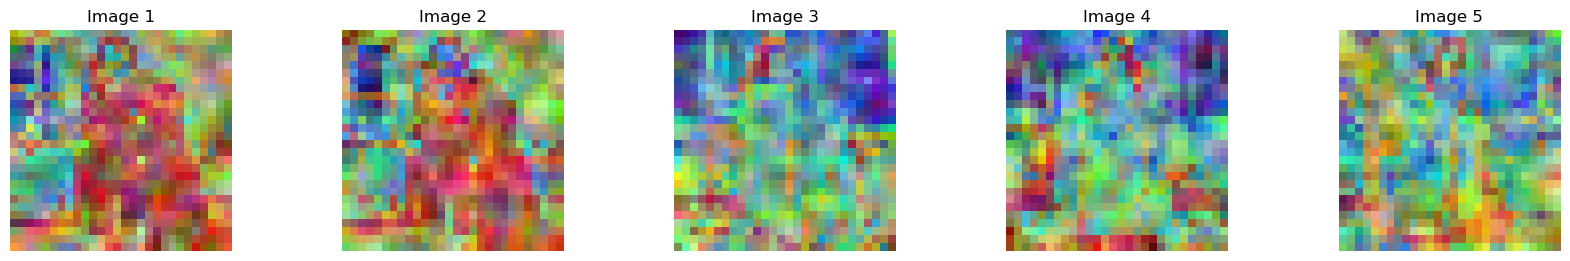

In [76]:
# Caminho para o diretório de teste
test_dir_indian = 'D:\\.Dataset28022024 - TCC\\result\\test\\indian'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_indian)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_indian, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

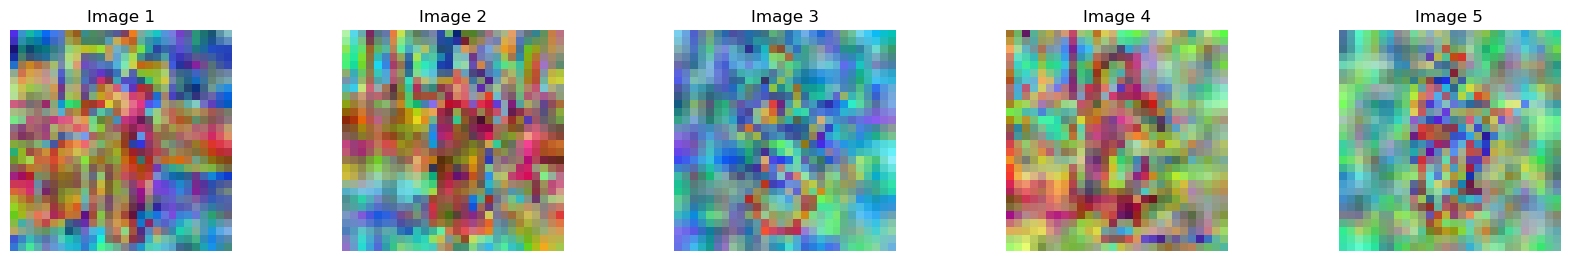

In [77]:
# Caminho para o diretório de teste
test_dir_japanese = 'D:\\.Dataset28022024 - TCC\\result\\test\\japanese'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_japanese)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_japanese, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

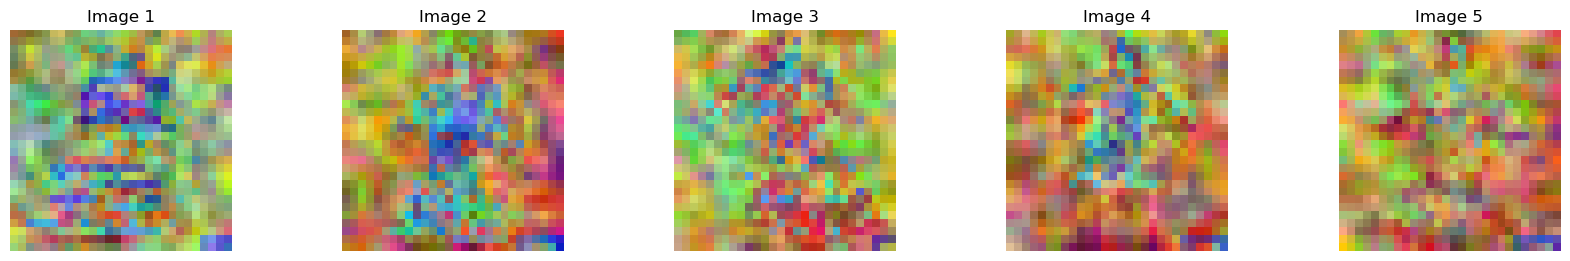

In [78]:
# Caminho para o diretório de teste
test_dir_spanish = 'D:\\.Dataset28022024 - TCC\\result\\test\\spanish'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_spanish)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_spanish, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

### Testing Model with other images

In [79]:
import cv2

In [80]:
german_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\Models\\test_image_labels\\german.jpg'
indian_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\Models\\test_image_labels\\indian.jpg'
japanese_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\Models\\test_image_labels\\japanese.jpg'
spanish_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\Models\\test_image_labels\\spanish.jpg'

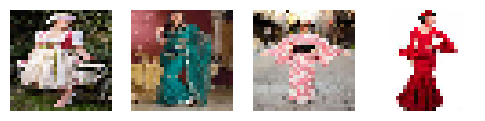

In [81]:
german = preprocess_image(german_path)
indian = preprocess_image(indian_path)
japanese = preprocess_image(japanese_path)
spanish = preprocess_image(spanish_path)

plt.figure(figsize=(6, 2))

plt.subplot(1, 4, 1)
plt.imshow(german)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(indian)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(japanese)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(spanish)
plt.axis('off')

plt.show()

In [82]:
german_normalized = german / 255.0
indian_normalized = indian / 255.0
japanese_normalized = japanese / 255.0
spanish_normalized = spanish / 255.0

# Suponha que você tenha um conjunto de dados com todas as imagens
all_images = np.array([german_normalized, indian_normalized, japanese_normalized, spanish_normalized])

# Use a função predict diretamente no conjunto de dados
all_predictions = model.predict(all_images)

threshold = 0.5  # Escolha um valor de limiar adequado

# Lista de nomes de labels correspondentes aos índices previstos
label_names = ['German', 'Indian', 'Japanese', 'Spanish']

# Iterar sobre as previsões para cada classe
for i, predictions in enumerate(all_predictions):
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    predicted_label = label_names[predicted_class]

    if confidence > threshold:
        print(f'Predicted class for sample {i + 1} is {predicted_label} with confidence {confidence}')
    else:
        print(f'Sample {i + 1} is None of the above')

1/1 [==============================] - 0s 135ms/step
Predicted class for sample 1 is Spanish with confidence 0.9472328424453735
Predicted class for sample 2 is Spanish with confidence 0.9472336173057556
Predicted class for sample 3 is Spanish with confidence 0.9472370147705078
Predicted class for sample 4 is Spanish with confidence 0.9472368359565735
